In [1]:
import pickle
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml

In [2]:
from matplotlib import rcParams
#rcParams['text.usetex'] = False
rcParams['font.family'] = 'cmr10'
rcParams['mathtext.fontset'] = 'cm'
rcParams['axes.formatter.use_mathtext'] = True

In [3]:
N_qubits=2
a_coeff=[0.32696, 0.80430]
J_coeff=[0.09]
print(a_coeff)
print(J_coeff)

[0.32696, 0.8043]
[0.09]


In [4]:
Ham=0
for i in range(N_qubits):
    Ham+=qml.PauliX(i)*a_coeff[i]

for i in range(N_qubits-1):
    Ham+= qml.PauliZ(i)@qml.PauliZ(i+1) * J_coeff[i]
print(Ham)

0.32696 * X(0) + 0.8043 * X(1) + 0.09 * (Z(0) @ Z(1))


### Exact Solution

In [5]:
eigenValues, eigenVectors = np.linalg.eigh(qml.matrix(Ham))

idx = eigenValues.argsort()[::1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

print(eigenValues)

[-1.13483443 -0.48575043  0.48575043  1.13483443]


In [6]:
rho0=qml.math.dm_from_state_vector(eigenVectors[:,0])
rho1=qml.math.dm_from_state_vector(eigenVectors[:,1])
rho2=qml.math.dm_from_state_vector(eigenVectors[:,2])
rho3=qml.math.dm_from_state_vector(eigenVectors[:,3])

### Ansatz

In [7]:
o_vectors=[[0, 0], [0, 1], [1, 0], [1, 1]]


dev = qml.device("default.qubit", wires=N_qubits)
@qml.qnode(dev)
def single_cost(params_in,vector):
    # Need to prepare a different orthogonal state each time
    qml.BasisState(np.array(vector), wires=range(N_qubits))
    
    # Unitary (https://arxiv.org/abs/1804.00633)
    qml.StronglyEntanglingLayers(weights=params_in, wires=range(N_qubits))
    
    return qml.expval(Ham)

In [8]:
@qml.qnode(dev)
def single_DM(params_in,vector):#, wires, state_idx=0):
    qml.BasisState(np.array(vector), wires=range(N_qubits))
    
    # Unitary (https://arxiv.org/abs/1804.00633)
    qml.StronglyEntanglingLayers(weights=params_in, wires=range(N_qubits))
    return qml.density_matrix(wires=range(N_qubits))

### Load Data

Here just use w4321 as example

In [9]:
with open('ISING_D4K4_w4321_parameters.pickle', 'rb') as f:
    params_set_exact = pickle.load(f)

In [10]:
k_number=4

In [11]:
w=np.array([4,3,2,1])
print('unnormalized w vector:',w )
w=w/sum(w)
print('normalized w vector:', np.round(w,4) )

unnormalized w vector: [4 3 2 1]
normalized w vector: [0.4 0.3 0.2 0.1]


In [12]:
# rho_w_exact
rho_w_exact=w[0]*rho0+w[1]*rho1+w[2]*rho2+w[3]*rho3
E_ensemble_ED=sum(w*eigenValues[0:4])
E_ensemble_ED

tensor(-0.38902537, requires_grad=True)

In [13]:
def total_cost(params):
    cost = 0
    for i in range(k_number):
        cost+=w[i]*single_cost(params,o_vectors[i])
    return cost

def total_DM(params):
    cost=0
    for i in range(k_number):
        cost+=w[i]*single_DM(params,o_vectors[i])
    return cost

### $\Delta \rho_w$

In [14]:
deltaEw=[]
for i in range(len(params_set_exact)):
    deltaEw.append((total_cost(params_set_exact[i])-E_ensemble_ED).real)

deltaE0=[]
deltaE1=[]
deltaE2=[]
deltaE3=[]


for i in range(len(params_set_exact)):
    de0=single_cost(params_set_exact[i],o_vectors[0])-eigenValues[0]
    de1=single_cost(params_set_exact[i],o_vectors[1])-eigenValues[1]
    de2=single_cost(params_set_exact[i],o_vectors[2])-eigenValues[2]
    de3=single_cost(params_set_exact[i],o_vectors[3])-eigenValues[3]
    deltaE0.append(de0.real)
    deltaE1.append(de1.real)
    deltaE2.append(de2.real)
    deltaE3.append(de3.real)

sum_abs_delta_Ei=[]
for i in range(len(deltaE0)):
    ans=abs(deltaE0[i])+abs(deltaE1[i])+abs(deltaE2[i])+abs(deltaE3[i])
    sum_abs_delta_Ei.append(ans)
delta_psi0=[]
delta_psi1=[]
delta_psi2=[]
delta_psi3=[]

for i in range(len(params_set_exact)):
    delta_psi0.append(1-qml.math.fidelity(single_DM(params_set_exact[i],o_vectors[0]),qml.math.dm_from_state_vector(np.array(eigenVectors[:,0]))))
    delta_psi1.append(1-qml.math.fidelity(single_DM(params_set_exact[i],o_vectors[1]),qml.math.dm_from_state_vector(np.array(eigenVectors[:,1]))))    
    delta_psi2.append(1-qml.math.fidelity(single_DM(params_set_exact[i],o_vectors[2]),qml.math.dm_from_state_vector(np.array(eigenVectors[:,2]))))    
    delta_psi3.append(1-qml.math.fidelity(single_DM(params_set_exact[i],o_vectors[3]),qml.math.dm_from_state_vector(np.array(eigenVectors[:,3]))))    

sum_delta_psi=[]
for i in range(len(delta_psi0)):
    ans=delta_psi0[i]+delta_psi1[i]+delta_psi2[i]+delta_psi3[i]
    sum_delta_psi.append(ans)

delta_rhow=[]

for i in range(len(params_set_exact)):
    rho_OP=total_DM(params_set_exact[i])-rho_w_exact
    ans=np.trace(np.matrix(rho_OP).getH()*np.matrix(rho_OP))
    delta_rhow.append(ans)


In [15]:
upper=max([(w[i]-w[i+1])/(eigenValues[i+1]-eigenValues[i]) for i in range(2**N_qubits-1)])
lower=min([(w[i]-w[i+1])/(eigenValues[i+1]-eigenValues[i]) for i in range(2**N_qubits-1)])

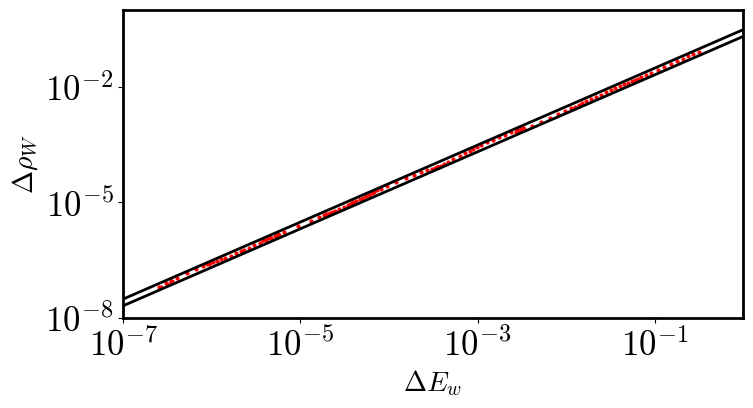

In [16]:
plt.figure(figsize=(8, 4))  
plt.loglog(deltaEw, np.array(delta_rhow).real,'r.',markersize=4)

plt.xlabel('$\Delta E_w$ ',fontsize=20)
plt.ylabel('$\Delta \\rho_W$ ',fontsize=20)

# upper bound
a= 2*upper
# lower bound
b= 2*lower
X = np.linspace(0, 1, 400)  # X values from -10 to 10
Y = a * X
Y2 = b*X
#plt.semilogx(X, Y,'k',linewidth=2)
#plt.semilogx(X, Y2,'k',linewidth=2)

plt.loglog(X, Y,'k',linewidth=2)
plt.loglog(X, Y2,'k',linewidth=2)
plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
#plt.legend(markerscale=2.5,loc='upper left', bbox_to_anchor=(0.45, 0.90), ncol=2,fontsize=20)

TK=plt.gca()
TK.spines['top'].set_linewidth(2)
TK.spines['bottom'].set_linewidth(2)
TK.spines['left'].set_linewidth(2)
TK.spines['right'].set_linewidth(2)

plt.xlim(left=1e-7,right=1)
plt.ylim(bottom=1e-8,top=1)
plt.show()

### $\Delta \Psi_1$

In [17]:
min(np.array([(w[1]-w[2])*(eigenValues[2]-eigenValues[1]),(w[0]-w[1])*(eigenValues[1]-eigenValues[0])  ]) )

tensor(0.0649084, requires_grad=True)

In [18]:
upper_1=1/min(np.array([(w[1]-w[2])*(eigenValues[2]-eigenValues[1]),(w[0]-w[1])*(eigenValues[1]-eigenValues[0])  ]) )

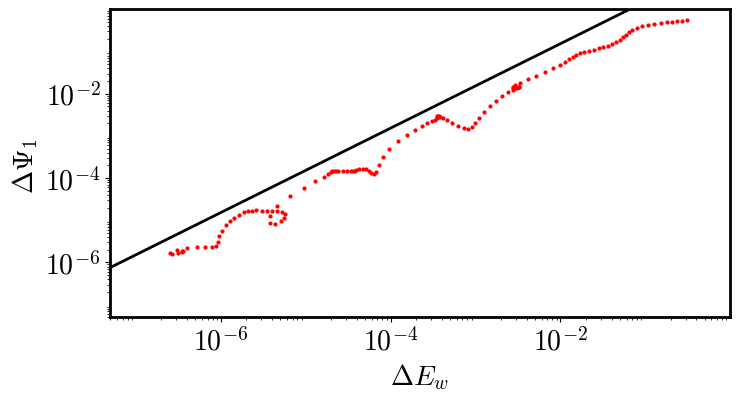

In [19]:
plt.figure(figsize=(8, 4))  
plt.loglog(deltaEw, delta_psi1,'r.',markersize=4)

plt.xlabel('$\Delta E_w$ ',fontsize=20)
plt.ylabel('$\Delta \Psi_1$ ',fontsize=20)

## upper bound
a= upper_1
X = np.linspace(0, 1, 400)  # X values from -10 to 10
Y = a * X
plt.semilogx(X, Y,'k',linewidth=2)



TK=plt.gca()
TK.spines['top'].set_linewidth(2)
TK.spines['bottom'].set_linewidth(2)
TK.spines['left'].set_linewidth(2)
TK.spines['right'].set_linewidth(2)

# Adjust ticks to roughly match the reference plot
plt.xticks([1e-6, 1e-4, 1e-2], labels=[r'$10^{-6}$', r'$10^{-4}$', r'$10^{-2}$'],fontsize=20)
plt.yticks([1e-6, 1e-4, 1e-2], labels=[r'$10^{-6}$', r'$10^{-4}$', r'$10^{-2}$'],fontsize=20)


plt.xlim(left=5*1e-8,right=1)
plt.ylim(bottom=5*1e-8,top=1)
plt.show()

### $\sum \Delta \Psi$

In [20]:
G_W_E=(w[0]-w[2**N_qubits-1])*(eigenValues[-1]-eigenValues[0])
G_W_E

g_w_e= min([(w[i]-w[i+1])*(eigenValues[i+1]-eigenValues[i]) for i in range(2**N_qubits-1)])

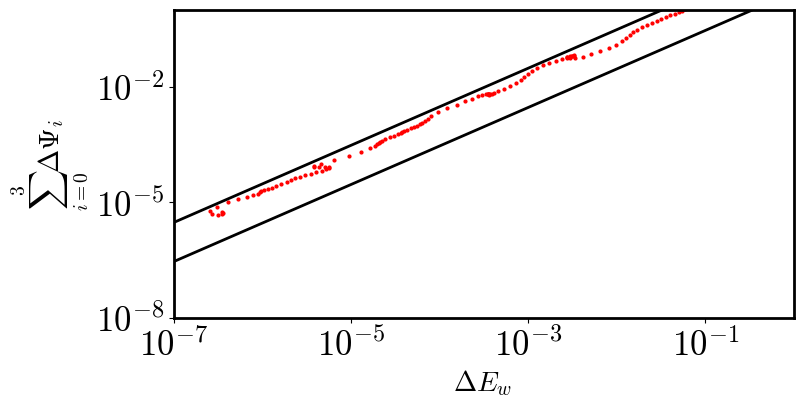

In [21]:
plt.figure(figsize=(8, 4))  
plt.loglog(deltaEw, sum_delta_psi,'r.',markersize=4)


plt.xlabel('$\Delta E_w$ ',fontsize=20)
plt.ylabel('$\sum_{i=0}^3 \Delta \\Psi_i$ ',fontsize=20)

# upper
a =2/g_w_e

# lower
b= 2/G_W_E
# Generate a range of X values
X = np.linspace(0, 1, 400)  


Y = a * X
Y2 = b*X
plt.loglog(X, Y,'k',linewidth=2)
plt.loglog(X, Y2,'k',linewidth=2)


plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)

#plt.legend(markerscale=2.5,loc='upper left', bbox_to_anchor=(0.45, 0.90), ncol=2,fontsize=20)

TK=plt.gca()
TK.spines['top'].set_linewidth(2)
TK.spines['bottom'].set_linewidth(2)
TK.spines['left'].set_linewidth(2)
TK.spines['right'].set_linewidth(2)

plt.xlim(left=1e-7,right=1)
plt.ylim(bottom=1e-8,top=1)

plt.show()

### $\Delta E_1$

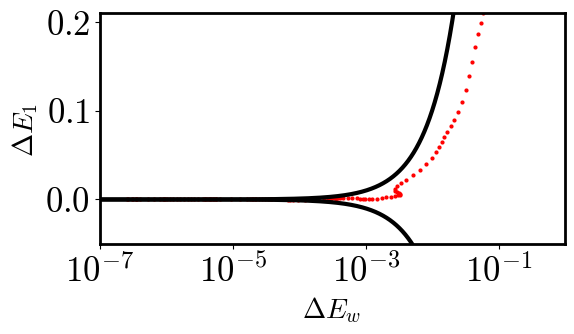

In [22]:
#plt.rc('font', size=18)
plt.figure(figsize=(6, 3))  

plt.semilogx(deltaEw, deltaE1,'r.',markersize=4)

plt.xlabel('$\Delta E_w$ ',fontsize=20)
plt.ylabel('$\Delta E_1$ ',fontsize=20)


# upper 
a = 1/(w[1]-w[2])

# lower
b=  1/(w[1]-w[0])
# Generate a range of X values
X = np.linspace(1e-8,1, 1000000).real

# Calculate Y values based on the equation Y = aX
Y = a * X
Y2 = b*X
plt.semilogx(X, Y,'k',linewidth=3)
plt.semilogx(X, Y2,'k',linewidth=3)


plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
#plt.legend(markerscale=2.5,loc='upper left', bbox_to_anchor=(0.45, 0.90), ncol=2,fontsize=20)

TK=plt.gca()
TK.spines['top'].set_linewidth(2)
TK.spines['bottom'].set_linewidth(2)
TK.spines['left'].set_linewidth(2)
TK.spines['right'].set_linewidth(2)


plt.ticklabel_format(axis='y', style='sci',useMathText=True)

#plt.ylim(-0.000005,6*1e-5)
plt.ylim(-0.05,0.21)

plt.xlim(left=1e-7,right=1)
plt.show()

### Small Window for $\Delta E_1$

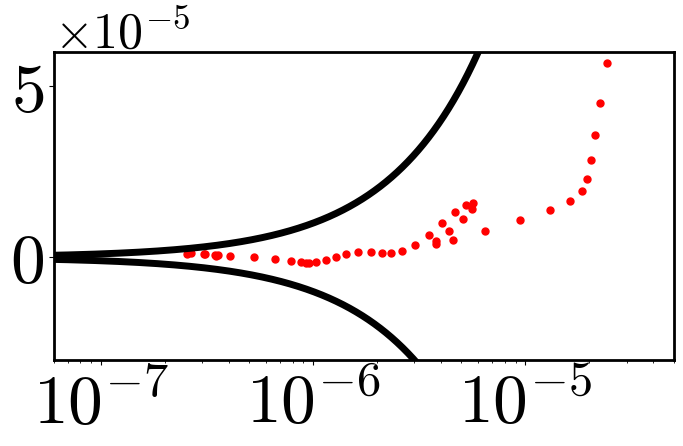

In [23]:
plt.rc('font', size=36)
plt.figure(figsize=(8, 4))  

plt.semilogx(deltaEw, deltaE1,'r.',markersize=10)


#plt.xlabel('$\Delta E_w$ ',fontsize=20)
#plt.ylabel('$\Delta E_1$ ',fontsize=20)


# upper 
a = 1/(w[1]-w[2])

# lower
b=  1/(w[1]-w[0])
# Generate a range of X values
X = np.linspace(1e-8,1e-4, 100000).real

# Calculate Y values based on the equation Y = aX
Y = a * X
Y2 = b*X
plt.semilogx(X, Y,'k',linewidth=5)
plt.semilogx(X, Y2,'k',linewidth=5)


plt.tick_params(axis='x', labelsize=50)
plt.tick_params(axis='y', labelsize=50)
#plt.legend(markerscale=2.5,loc='upper left', bbox_to_anchor=(0.45, 0.90), ncol=2,fontsize=20)

TK=plt.gca()
TK.spines['top'].set_linewidth(2)
TK.spines['bottom'].set_linewidth(2)
TK.spines['left'].set_linewidth(2)
TK.spines['right'].set_linewidth(2)


plt.ticklabel_format(axis='y', style='sci',useMathText=True)

plt.ylim(-3*1e-5,6*1e-5)
plt.xlim(left=6*1e-8,right=5*1e-5)


plt.show()

### $ \sum \Delta E_k$

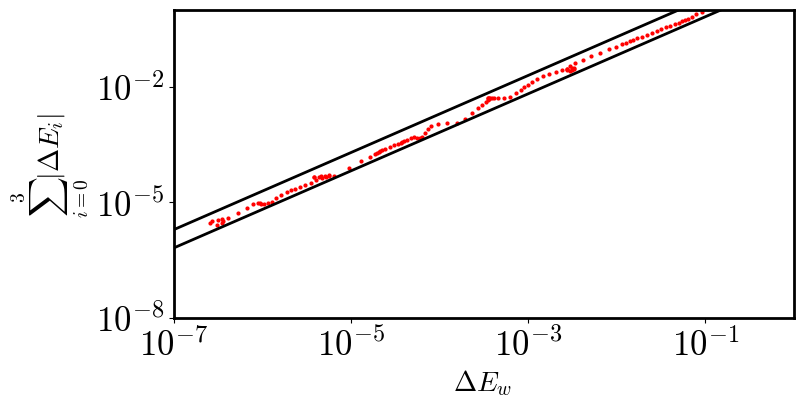

In [24]:
plt.figure(figsize=(8, 4))  

plt.loglog(deltaEw, sum_abs_delta_Ei,'r.',markersize=4)


plt.xlabel('$\Delta E_w$ ',fontsize=20)
plt.ylabel('$\sum_{i=0}^3 |\Delta E_i|$ ',fontsize=20)

#upper 
a =2/ min([w[i]-w[i+1] for i in range(2**N_qubits-1)])

#lower
b= 2/(w[0]-w[-1])

X = np.linspace(0, 1, 400)  

# Calculate Y values based on the equation Y = aX
Y = a * X
Y2 = b*X
plt.loglog(X, Y,'k',linewidth=2)
plt.loglog(X, Y2,'k',linewidth=2)


plt.tick_params(axis='x', labelsize=25)
plt.tick_params(axis='y', labelsize=25)
#plt.legend(markerscale=2.5,loc='upper left', bbox_to_anchor=(0.45, 0.90), ncol=2,fontsize=20)

TK=plt.gca()
TK.spines['top'].set_linewidth(2)
TK.spines['bottom'].set_linewidth(2)
TK.spines['left'].set_linewidth(2)
TK.spines['right'].set_linewidth(2)


plt.xlim(left=1e-7,right=1)
plt.ylim(bottom=1e-8,top=1)


plt.show()